# 风格迁移实现

In [13]:
import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

#检查到有GPU，就用它来计算
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

# 一.准备输入文件
准备两张照片，一张作为风格图，一张作为内容

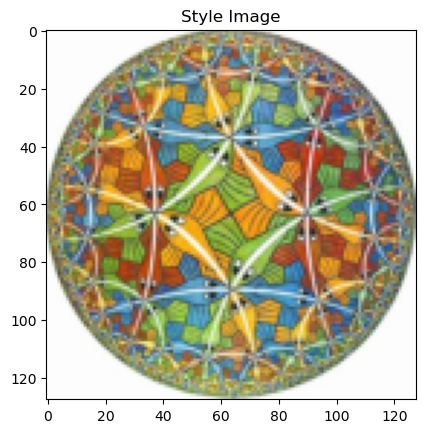

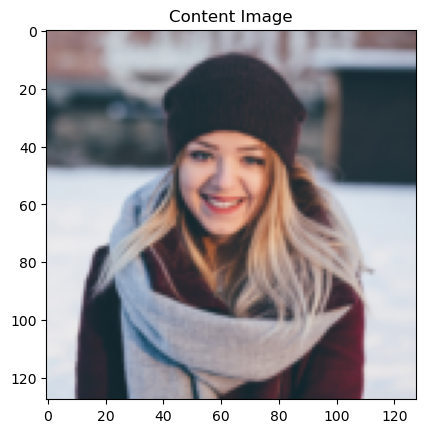

In [14]:
style = 'images/escher.jpg'
content = 'images/portrait1.jpg'

style_weight = 1000
content_weight = 1

imsize = 128

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).clone().detach().requires_grad_(True)
    image = image.unsqueeze(0)
    return image

style_img = image_loader(style).type(dtype)
content_img = image_loader(content).type(dtype)

assert style_img.size() == content_img.size()

unloader = transforms.ToPILImage() #Python Imaging Library图像
plt.ion()

def imshow(tensor, title = None):
    image = tensor.clone().cpu()
    image = image.view(3, imsize, imsize)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
plt.figure()
imshow(style_img.data, title = 'Style Image')

plt.figure()
imshow(content_img.data, title = 'Content Image')

# 二.风格迁移网络实现
将已训练好的cnn直接迁移过来，输入一张图像a，让b图像生成和这个风格相似的c图像
为了实现风格迁移，构建计算图来加速计算：
    step1：加载一个训练好的cnn；
        step2：在原网络的基础上添加计算风格损失和内容损失的新计算层

##  step1：加载一个训练好的大型网络VGG

In [16]:
cnn = models.vgg19(pretrained = True).features

if use_cuda:
    cnn = cnn.cuda()

## step2：重新定义新的计算模块

In [38]:
class ContentLoss(nn.Module):
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()
    
    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output
    
    def backward(self, retain_variables = True):
        self.loss.backward()
        return self.loss
    
class StyleLoss(nn.Module):
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()
    
    def forward(self, input):
        self.output = input.clone()
        input = input.cuda() if use_cuda else input
        self_G = Gram(input)
        self_G.mul_(self.weight)
        
        self.loss = self.criterion(self_G, self.target)
        return self.output
    
    def backward(self, retain_variables = True):
        self.loss.backward(retain_graph = True)
        return self.loss

def Gram(input):
        a, b, c, d = input.size()
        features = input.view(a * b, c * d)
        
        G = torch.mm(features, features.t())
        
        return G.div(a * b * c * d)

In [39]:
content_layers = ['conv_4']

style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

content_losses = []
style_losses = []

model = nn.Sequential()  

if use_cuda:
    model = model.cuda()


i = 1
for layer in list(cnn):
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(i)
        model.add_module(name, layer)

        if name in content_layers:
           
            target = model(content_img).clone() 
            content_loss = ContentLoss(target, content_weight) 
            content_loss = content_loss if use_cuda else content_loss
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).clone()
            target_feature = target_feature.cuda() if use_cuda else target_feature
            target_feature_gram = Gram(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            style_loss = style_loss.cuda() if use_cuda else style_loss
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

    if isinstance(layer, nn.ReLU):
        name = "relu_" + str(i)
        model.add_module(name, layer)

        i += 1

    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(i)
        model.add_module(name, layer)  # ***


# 三.风格迁移的训练

## step1：准备一张原始的图像，可以是噪音图或者内容图

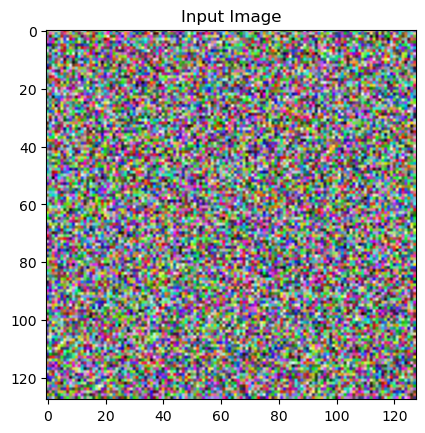

In [40]:
#噪声图像开始
input_img = torch.randn(content_img.data.size(), requires_grad = True)

if use_cuda:
    input_img = input_img.cuda()
    content_img = content_img.cuda()
    style_img = style_img.cuda()
# 将选中的待调整图打印出来:
plt.figure()
imshow(input_img.data, title='Input Image')

## step2：优化输入图像（训练）

正在构造风格迁移模型..
开始优化..
运行 0轮:
风格损失 : 29626.726562 内容损失: 25.021292

运行 50轮:
风格损失 : 12.836382 内容损失: 13.193998

运行 100轮:
风格损失 : 6.342379 内容损失: 11.217316

运行 150轮:
风格损失 : 4.310407 内容损失: 9.685451

运行 200轮:
风格损失 : 3.262695 内容损失: 8.403747

运行 250轮:
风格损失 : 2.491394 内容损失: 7.589060



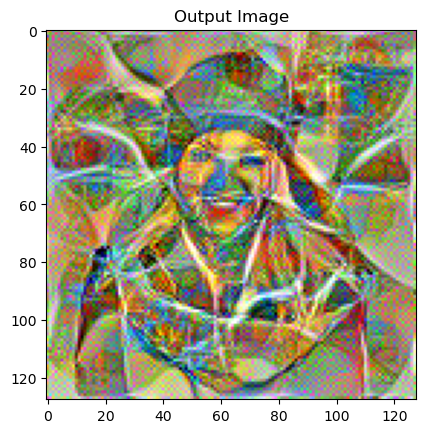

In [41]:
# 首先，需要先讲输入图像变成神经网络的参数，这样我们就可以用反向传播算法来调节这个输入图像了
input_param = nn.Parameter(input_img.data)

#定义个优化器，采用LBFGS优化算法来优化（试验效果很好，它的特点是可以计算大规模数据的梯度下降）
optimizer = optim.LBFGS([input_param])

# 迭代步数
num_steps=300


"""运行风格迁移的主算法过程."""
print('正在构造风格迁移模型..')

print('开始优化..')
for i in range(num_steps):
    #每一个训练周期
    
    # 限制输入图像的色彩取值范围在0-1间
    input_param.data.clamp_(0, 1)
    
    # 清空梯度
    optimizer.zero_grad()
    # 将图像输入构造的神经网络中
    model(input_param)
    style_score = 0
    content_score = 0
    
    # 每个损失函数层都开始反向传播算法
    for sl in style_losses:
        style_score += sl.backward()
    for cl in content_losses:
        content_score += cl.backward()

    # 每隔50个周期打印一次训练数据
    if i % 50 == 0:
        print("运行 {}轮:".format(i))
        print('风格损失 : {:4f} 内容损失: {:4f}'.format(
            style_score.data.item(), content_score.data.item()))
        print()
    def closure():
        return style_score + content_score
    #一步优化
    optimizer.step(closure)

# 做一些修正，防止数据超界...
output = input_param.data.clamp_(0, 1)

# 打印结果图
plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()